In [1]:
import numpy as np
import pandas as pd
import os, time
from scipy import stats
import matplotlib.pyplot as plt
from CPSI import chord_progression_simplification, progression_group_simplification
from CPSI import similarity_index_v1, similarity_index_v2, root_similarity_index_v1, root_similarity_index_v2 

In [2]:
pathList = os.listdir("ExperimentalData")
df_total = pd.DataFrame(columns = ["rt", "stimulus", "response", "trial_type", "trial_index", "time_elapsed", 
                             "internal_node_id", "question_order", "slider_start", "trial_number"])
for path in pathList:
    file = pd.read_csv("ExperimentalData/" + path)
    df1 = pd.DataFrame(file)
    df1["trial_number"] = path
    df1.drop(["rt", "trial_type", "trial_index", "internal_node_id", "question_order", "slider_start"], axis = 1)
    df1.drop([0, 45])
    df1 = df1.sort_values(by = "stimulus", ascending = True, na_position = "first", ignore_index = True)
    df_total = pd.concat([df_total, df1])

In [3]:
print(len(df_total))
df_total.head()

1564


,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
0,22023,NaN,"{""part_age"":""Male""}",survey-html-form,1,30268,0.0-1.0,NaN,NaN,Chords_final_2022-9-12_19:39.csv
1,43640,NaN,"{""WesternGenres"":[""Classical"",""Pop"",""Rock"",""Ja...",survey-multi-select,2,73914,0.0-2.0,"[0,1,2,3,4]",NaN,Chords_final_2022-9-12_19:39.csv
2,7909,NaN,"{""Instrument"":""5-10"",""ChordalInstrument"":""Yes""...",survey-multi-choice,3,81829,0.0-3.0,"[0,1,2,3]",NaN,Chords_final_2022-9-12_19:39.csv
3,1950,NaN,"{""Q0"":""""}",survey-text,45,1055446,0.0-6.0,NaN,NaN,Chords_final_2022-9-12_19:39.csv
4,8213,"<h1 class=""title"">Consent Form</h1> </header> ...",0,html-button-response,0,8242,0.0-0.0,NaN,NaN,Chords_final_2022-9-12_19:39.csv


# Standardization

In [4]:
df2 = df_total.dropna(subset=["stimulus"])
df_stimulus = df2[df2.stimulus.str.contains("audio//part")]
df_stimulus.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
6,16920,audio//part0_pair1.wav,1,audio-slider-response,7,153481,0.0-5.0-0.2,NaN,50.0,Chords_final_2022-9-12_19:39.csv
7,31901,audio//part0_pair2.wav,35,audio-slider-response,32,749583,0.0-5.0-0.27,NaN,50.0,Chords_final_2022-9-12_19:39.csv
8,16992,audio//part0_pair3.wav,10,audio-slider-response,11,260631,0.0-5.0-0.6,NaN,50.0,Chords_final_2022-9-12_19:39.csv
9,27029,audio//part0_pair4.wav,100,audio-slider-response,35,826093,0.0-5.0-0.30,NaN,50.0,Chords_final_2022-9-12_19:39.csv
10,33568,audio//part0_pair5.wav,85,audio-slider-response,6,136481,0.0-5.0-0.1,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [5]:
df_stimulus_scale = pd.DataFrame(columns = ["rt", "stimulus", "response", "trial_type", "trial_index", "time_elapsed", 
                             "internal_node_id", "question_order", "slider_start", "trial_number"])
for i in range(len(df_stimulus)//40): 
    rows = df_stimulus[i*40:i*40+40].copy()
    rows.response = (rows.response.astype(float)-rows.response.astype(float).mean())/rows.response.astype(float).std()
    df_stimulus_scale = pd.concat([df_stimulus_scale, rows])
df_stimulus_scale.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
6,16920,audio//part0_pair1.wav,-1.457486,audio-slider-response,7,153481,0.0-5.0-0.2,NaN,50.0,Chords_final_2022-9-12_19:39.csv
7,31901,audio//part0_pair2.wav,-0.034528,audio-slider-response,32,749583,0.0-5.0-0.27,NaN,50.0,Chords_final_2022-9-12_19:39.csv
8,16992,audio//part0_pair3.wav,-1.080821,audio-slider-response,11,260631,0.0-5.0-0.6,NaN,50.0,Chords_final_2022-9-12_19:39.csv
9,27029,audio//part0_pair4.wav,2.685835,audio-slider-response,35,826093,0.0-5.0-0.30,NaN,50.0,Chords_final_2022-9-12_19:39.csv
10,33568,audio//part0_pair5.wav,2.058059,audio-slider-response,6,136481,0.0-5.0-0.1,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [6]:
df = df_stimulus_scale.copy()

# Differences between ninth and seventh chord? YES!

In [7]:
seventh = ["audio//part4_pair1.wav", "audio//part4_pair2.wav", "audio//part4_pair3.wav", "audio//part4_pair4.wav", "audio//part4_pair5.wav"]
ninth = ["audio//part4_pair6.wav", "audio//part4_pair7.wav", "audio//part4_pair8.wav", "audio//part4_pair9.wav", "audio//part4_pair10.wav"]
triads = ["audio//part0_pair1.wav", "audio//part0_pair2.wav", "audio//part0_pair3.wav"]
df_seventh = df[df.stimulus.isin(seventh)]
df_ninth = df[df.stimulus.isin(ninth)]
df_triads = df[df.stimulus.isin(triads)]

df_seventh.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
36,19381,audio//part4_pair1.wav,-0.913414,audio-slider-response,26,570677,0.0-5.0-0.21,NaN,50.0,Chords_final_2022-9-12_19:39.csv
38,18691,audio//part4_pair2.wav,-0.369342,audio-slider-response,5,102835,0.0-5.0-0.0,NaN,50.0,Chords_final_2022-9-12_19:39.csv
39,21800,audio//part4_pair3.wav,-0.536748,audio-slider-response,40,928003,0.0-5.0-0.35,NaN,50.0,Chords_final_2022-9-12_19:39.csv
40,16779,audio//part4_pair4.wav,0.132879,audio-slider-response,25,551216,0.0-5.0-0.20,NaN,50.0,Chords_final_2022-9-12_19:39.csv
41,19600,audio//part4_pair5.wav,1.262876,audio-slider-response,20,460984,0.0-5.0-0.15,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [8]:
x_seventh = df_seventh.response.astype(int).to_list()
x_ninth = df_ninth.response.astype(int).to_list()
x_triads = df_triads.response.astype(int).to_list()

In [9]:
stats.ttest_ind(x_seventh, x_ninth)

Ttest_indResult(statistic=-5.152990511392732, pvalue=4.368357094828787e-07)

In [10]:
stats.ttest_ind(x_seventh, x_triads)

Ttest_indResult(statistic=6.155236603192452, pvalue=2.7000679260705218e-09)

In [11]:
stats.ttest_ind(x_ninth, x_triads)

Ttest_indResult(statistic=10.240700719165275, pvalue=5.228290759278443e-21)

We can get the conclusion that ninth chords and seventh chords have significant difference for human perceptual.

# Differences between same loops and different loops? NO!

In [12]:
sameLoop = ["audio//part2_pair1.wav", "audio//part2_pair2.wav", "audio//part2_pair3.wav", 
            "audio//part2_pair4.wav", "audio//part2_pair5.wav", "audio//part2_pair6.wav"]
diffLoop = ["audio//part2_pair7.wav", "audio//part2_pair8.wav", "audio//part2_pair9.wav", "audio//part2_pair10.wav", 
            "audio//part2_pair11.wav", "audio//part2_pair12.wav", "audio//part2_pair13.wav"]

df_sameLoop = df[df.stimulus.isin(sameLoop)]
df_diffLoop = df[df.stimulus.isin(diffLoop)]

df_sameLoop.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
17,28899,audio//part2_pair1.wav,-0.076379,audio-slider-response,9,216652,0.0-5.0-0.4,NaN,50.0,Chords_final_2022-9-12_19:39.csv
22,40061,audio//part2_pair2.wav,-0.536748,audio-slider-response,28,647745,0.0-5.0-0.23,NaN,50.0,Chords_final_2022-9-12_19:39.csv
23,32149,audio//part2_pair3.wav,-0.5786,audio-slider-response,34,798985,0.0-5.0-0.29,NaN,50.0,Chords_final_2022-9-12_19:39.csv
24,18509,audio//part2_pair4.wav,0.174731,audio-slider-response,22,500930,0.0-5.0-0.17,NaN,50.0,Chords_final_2022-9-12_19:39.csv
25,20571,audio//part2_pair5.wav,-0.118231,audio-slider-response,36,846744,0.0-5.0-0.31,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [13]:
x_sameLoop = df_sameLoop.response.astype(int).to_list()
x_diffLoop = df_diffLoop.response.astype(int).to_list()

In [14]:
stats.ttest_ind(x_sameLoop, x_diffLoop)

Ttest_indResult(statistic=-1.5263651657557187, pvalue=0.12763742504734185)

We can get the conclusion that same loop chords and different loop chords don't have significant differences for human perceptual.

# What if between the same loops? NO!

In [15]:
df_same1 = df[df.stimulus=="audio//part2_pair1.wav"]
df_same2 = df[df.stimulus=="audio//part2_pair2.wav"]
df_same3 = df[df.stimulus=="audio//part2_pair3.wav"]
df_same4 = df[df.stimulus=="audio//part2_pair4.wav"]
df_same5 = df[df.stimulus=="audio//part2_pair5.wav"]

df_same1.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
17,28899,audio//part2_pair1.wav,-0.076379,audio-slider-response,9,216652,0.0-5.0-0.4,NaN,50.0,Chords_final_2022-9-12_19:39.csv
17,18829,audio//part2_pair1.wav,0.71021,audio-slider-response,7,236794,0.0-5.0-0.2,NaN,50.0,Chords_final_2022-5-18_17:14.csv
17,26120,audio//part2_pair1.wav,-0.883558,audio-slider-response,8,136296,0.0-5.0-0.3,NaN,50.0,Chords_final_2022-9-5_17:30.csv
17,19830,audio//part2_pair1.wav,0.169759,audio-slider-response,29,649388,0.0-5.0-0.24,NaN,50.0,Chords_final_2022-9-6_18:9.csv
17,26807,audio//part2_pair1.wav,-1.144674,audio-slider-response,19,470485,0.0-5.0-0.14,NaN,50.0,Chords_final_9-14-2022_21:8.csv


In [16]:
x_same1 = df_same1.response.astype(int).to_list()
x_same2 = df_same2.response.astype(int).to_list()
x_same3 = df_same3.response.astype(int).to_list()
x_same4 = df_same4.response.astype(int).to_list()
x_same5 = df_same5.response.astype(int).to_list()

In [17]:
stats.f_oneway(x_same1, x_same2, x_same3, x_same4, x_same5)

F_onewayResult(statistic=1.8387096774193548, pvalue=0.12378675436221907)

We can get the conclusion that there are not significant difference between same loop chords according to human perceptual.

# Will chord length influence human perceptual? YES!

In [18]:
length = ["audio//part1_pair1.wav", "audio//part1_pair2.wav", "audio//part1_pair3.wav", 
            "audio//part1_pair4.wav", "audio//part1_pair5.wav"]
calibration = ["audio//part0_pair1.wav", "audio//part0_pair2.wav", "audio//part0_pair3.wav"]

df_length = df[df.stimulus.isin(length)]
df_calibration = df[df.stimulus.isin(calibration)]

df_length.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
12,18221,audio//part1_pair1.wav,0.007324,audio-slider-response,39,906119,0.0-5.0-0.34,NaN,50.0,Chords_final_2022-9-12_19:39.csv
13,22331,audio//part1_pair2.wav,-0.494897,audio-slider-response,15,350224,0.0-5.0-0.10,NaN,50.0,Chords_final_2022-9-12_19:39.csv
14,34120,audio//part1_pair3.wav,-0.955266,audio-slider-response,8,187680,0.0-5.0-0.3,NaN,50.0,Chords_final_2022-9-12_19:39.csv
15,35309,audio//part1_pair4.wav,1.430283,audio-slider-response,18,419221,0.0-5.0-0.13,NaN,50.0,Chords_final_2022-9-12_19:39.csv
16,21269,audio//part1_pair5.wav,-0.620452,audio-slider-response,21,482343,0.0-5.0-0.16,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [19]:
x_length = df_length.response.astype(int).to_list()
x_calibration = df_calibration.response.astype(int).to_list()

In [20]:
stats.ttest_ind(x_length, x_calibration)

Ttest_indResult(statistic=4.87994989083052, pvalue=1.816717217721476e-06)

We can get the conclusion that there are significant difference if the length of chord progressions changes.

# Will last chord influence people's perception? YES!

In [21]:
last = ["audio//part3_pair1.wav", "audio//part3_pair2.wav", "audio//part3_pair3.wav", 
            "audio//part3_pair4.wav", "audio//part3_pair5.wav", "audio//part3_pair6.wav"]
df_last = df[df.stimulus.isin(last)]
df_last.head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
30,18312,audio//part3_pair1.wav,-0.536748,audio-slider-response,38,887796,0.0-5.0-0.33,NaN,50.0,Chords_final_2022-9-12_19:39.csv
31,15880,audio//part3_pair2.wav,-0.662304,audio-slider-response,16,366173,0.0-5.0-0.11,NaN,50.0,Chords_final_2022-9-12_19:39.csv
32,23560,audio//part3_pair3.wav,-0.243786,audio-slider-response,13,310100,0.0-5.0-0.8,NaN,50.0,Chords_final_2022-9-12_19:39.csv
33,22000,audio//part3_pair4.wav,-0.829711,audio-slider-response,19,441305,0.0-5.0-0.14,NaN,50.0,Chords_final_2022-9-12_19:39.csv
34,36832,audio//part3_pair5.wav,-0.746007,audio-slider-response,27,607597,0.0-5.0-0.22,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [22]:
x_last = df_last.response.astype(int).to_list()
stats.ttest_ind(x_last, x_calibration)

Ttest_indResult(statistic=5.828831884880799, pvalue=1.4236185387759234e-08)

We can get the conclusion that there are significant difference if the last chord of the chord progressions changes.

# Plots

In [23]:
colors = ["red", "black", "orange", "blue", "green"]
audio_class = ["part0", "part1", "part2", "part3", "part4"]
df_stimulus_scale[df_stimulus_scale.stimulus.str.contains("part0")].head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
6,16920,audio//part0_pair1.wav,-1.457486,audio-slider-response,7,153481,0.0-5.0-0.2,NaN,50.0,Chords_final_2022-9-12_19:39.csv
7,31901,audio//part0_pair2.wav,-0.034528,audio-slider-response,32,749583,0.0-5.0-0.27,NaN,50.0,Chords_final_2022-9-12_19:39.csv
8,16992,audio//part0_pair3.wav,-1.080821,audio-slider-response,11,260631,0.0-5.0-0.6,NaN,50.0,Chords_final_2022-9-12_19:39.csv
9,27029,audio//part0_pair4.wav,2.685835,audio-slider-response,35,826093,0.0-5.0-0.30,NaN,50.0,Chords_final_2022-9-12_19:39.csv
10,33568,audio//part0_pair5.wav,2.058059,audio-slider-response,6,136481,0.0-5.0-0.1,NaN,50.0,Chords_final_2022-9-12_19:39.csv


part 0:  0.1323529411764706
part 1:  -0.11764705882352941
part 2:  0.029411764705882353
part 3:  -0.06372549019607843
part 4:  0.21764705882352942


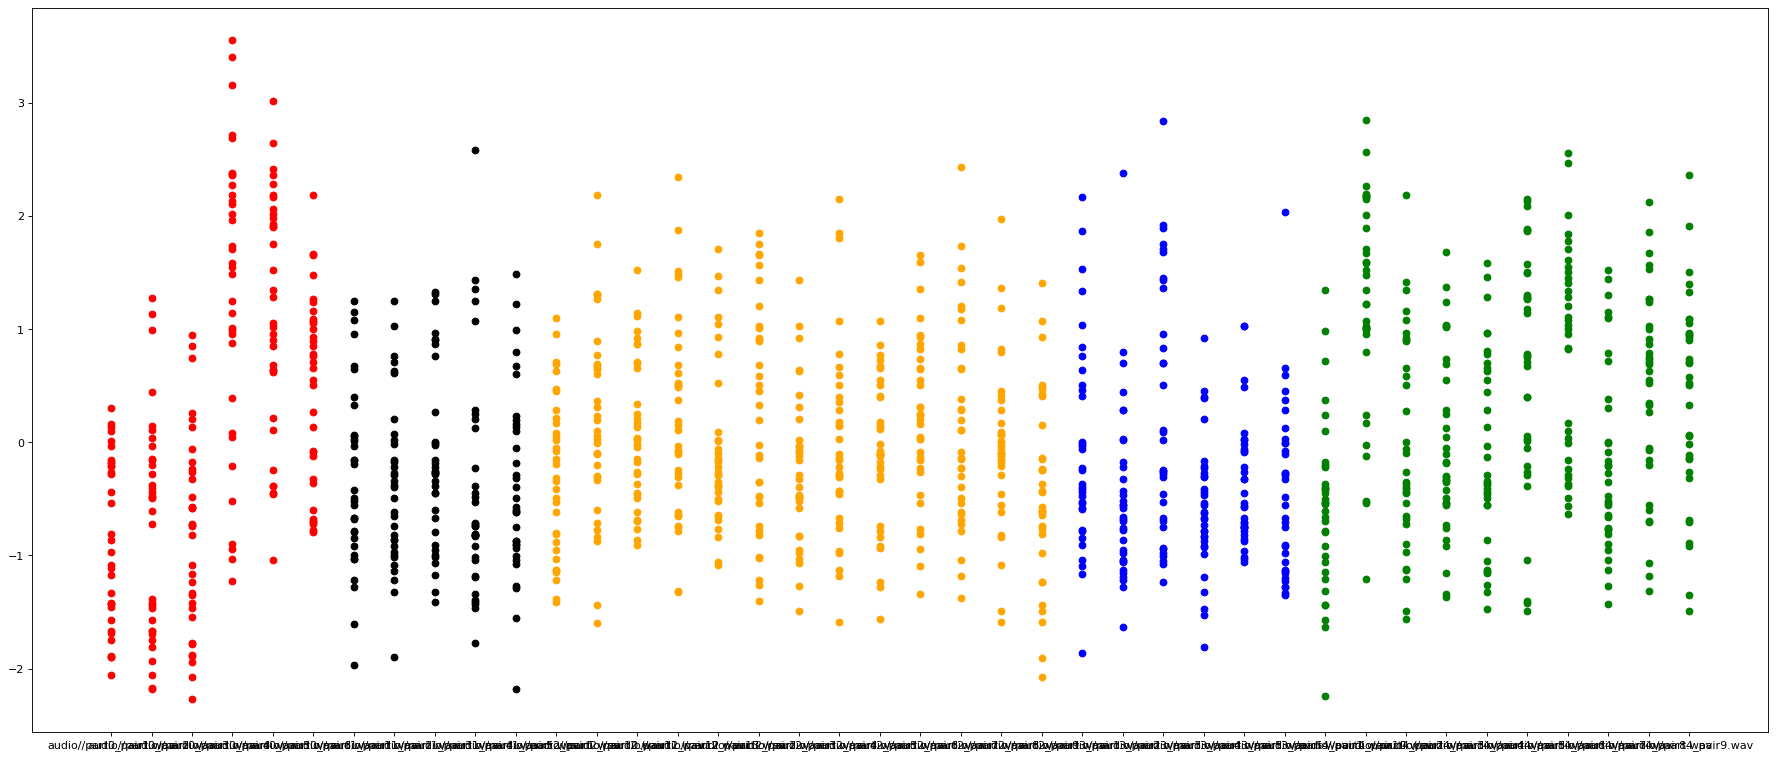

In [24]:
plt.figure(figsize=(28, 12), dpi=80)
for i in range(len(audio_class)):
    dataplot = df_stimulus_scale[df_stimulus_scale.stimulus.str.contains(audio_class[i])]
    print("part %d: "%i, np.mean(dataplot.response.astype(int)))
    plt.scatter(dataplot.stimulus, dataplot.response, c = colors[i])

# CPSI for Different Versions
+ Version 1.x: No weight for chords; Version 2.x: Add weight to leading chord
+ Version x.1: Non-simplified chords; Version x.2: Simplified chords; Version x.3: Root transition

In [25]:
design = {
    "part0_pair1":[["C","Am","F","G"], ["C","Am","F","G"]],"part0_pair2":[["C","F","G","C"],["C","F","G","C"]],
    "part0_pair3":[["Am","F","G","C"],["Am","F","G","C"]],"part0_pair4":[["C","Am","F","G"],["Am","Em","Am","Em"]],
    "part0_pair5":[["C","Am","F","G"],["Em","C","Dm","Em"]],"part0_pair6":[["C","Am","F","G"],["C","G","Em","C"]],
    "part1_pair1":[["C","Am","F","G"],["C","Am","F","G","C"]],
    "part1_pair2":[["C","F","G","C"],["C","F","G","Am","C"]],
    "part1_pair3":[["F","G","Em","Am"],["F","G","Em","Am","C"]],
    "part1_pair4":[["Am","F","G","C"],["Am","F","G","C","Am"]],
    "part1_pair5":[["C","Em","F","G"],["C","Em","F","G","C"]],"part2_pair1":[["C","Am","F","G"],["Am","F","G","C"]],
    "part2_pair2":[["C","Am","F","G"],["F","G","C","Am"]],"part2_pair3":[["C","Am","F","G"],["G","C","Am","F"]], 
    "part2_pair4":[["Am","F","G","C"],["F","G","C","Am"]],"part2_pair5":[["Am","F","G","C"],["G","C","Am","F"]],
    "part2_pair6":[["F","G","C","Am"],["G","C","Am","F"]],"part2_pair7":[["C","Am","F","G"],["Am","C","F","G"]],
    "part2_pair8":[["C","Am","F","G"],["F","Am","C","G"]],"part2_pair9":[["C","Am","F","G"],["F","Am","C","G"]],
    "part2_pair10":[["C","Am","F","G"],["G","Am","F","C"]],"part2_pair11":[["C","Am","F","G"],["C","F","Am","G"]],
    "part2_pair12":[["C","Am","F","G"],["C","G","F","Am"]],"part2_pair13":[["C","Am","F","G"],["C","Am","G","F"]],
    "part3_pair1": [[["Am","F","G","Am"],["Am","F","G","Am"]],[["Am","F","G","Am"],["Am","F","G","Em"]]],
    "part3_pair2": [[["F","G","Am"],["F","G","Am"]],[["F","G","Am"], ["F","G","C"]]],
    "part3_pair3": [[["C","Dm","Bm","Em"],["C","Dm","Bm","Em"]],[["C","Dm","Bm","Em"],["C","Dm","Bm","B"]]],
    "part3_pair4": [[["Am","Em","F","Em"],["Am","Em","F","Em"]],[["Am","Em","F","Em"],["Am","Em","F","Am"]]],
    "part3_pair5": [[["F","G","Em","Am"],["F","G","Em","Am"]],[["F","G","Em","Am"],["F","G","Em","Am"]]],
    "part3_pair6": [[["C","G","Am","Em"],["C","G","Am","Em"]],[["C","G","Am","Em"],["C","G","Am","C"]]],
    "part4_pair1":[["F","G","Em","Am"],["F","G","Em7","Am"]],
    "part4_pair2":[["F","G","Em","Am"],["F","G","Em","Am7"]],
    "part4_pair3":[["F","G","Em","Am"],["F","G7","Em","Am"]],
    "part4_pair4":[["F","G","Em","Am"],["Fmaj7","G","Em","Am"]],
    "part4_pair5":[["F","G","Em","Am"],["Fmaj7","G7","Em7","Am7"]],
    "part4_pair6":[["F","G","Em","Am"],["F9","G","Em","Am"]],
    "part4_pair7":[["F","G","Em","Am"],["F","G9","Em","Am"]],
    "part4_pair8":[["F","G","Em","Am"],["F","G","Em9","Am"]],
    "part4_pair9":[["F","G","Em","Am"],["F","G","Em","Am9"]],
    "part4_pair10":[["F","G","Em","Am"],["F9","G9","Em9","Am9"]]
}
#

In [26]:
song1,song2 = [["F","G","Em","A"],["F9","G9","Em9","Am9"]],[["F","G","Em","Am"],["F9","G9","Em9","Am9"]]
similarity_index_v1(song1,song2,0.5,0.5)

[0.49210776887836927, 0.49210776887836927]

In [27]:
CPSIdata = {"PairName":[],"Version1.1":[],"Version1.2":[],"Version1.3":[],
            "Version2.1":[],"Version2.2":[],"Version2.3":[]}

In [28]:
df_test = df.copy()
df_test.stimulus = df_test["stimulus"].str.slice_replace(0, 7, "")
df_test.stimulus = df_test["stimulus"].str.strip(".wav")
df_test

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
6,16920,part0_pair1,-1.457486,audio-slider-response,7,153481,0.0-5.0-0.2,NaN,50.0,Chords_final_2022-9-12_19:39.csv
7,31901,part0_pair2,-0.034528,audio-slider-response,32,749583,0.0-5.0-0.27,NaN,50.0,Chords_final_2022-9-12_19:39.csv
8,16992,part0_pair3,-1.080821,audio-slider-response,11,260631,0.0-5.0-0.6,NaN,50.0,Chords_final_2022-9-12_19:39.csv
9,27029,part0_pair4,2.685835,audio-slider-response,35,826093,0.0-5.0-0.30,NaN,50.0,Chords_final_2022-9-12_19:39.csv
10,33568,part0_pair5,2.058059,audio-slider-response,6,136481,0.0-5.0-0.1,NaN,50.0,Chords_final_2022-9-12_19:39.csv
...,...,...,...,...,...,...,...,...,...,...
41,20509,part4_pair5,1.175607,audio-slider-response,44,986631,0.0-5.0-0.39,NaN,50.0,Chords_final_2022-9-7_17:8.csv
42,26101,part4_pair6,1.453858,audio-slider-response,31,677833,0.0-5.0-0.26,NaN,50.0,Chords_final_2022-9-7_17:8.csv
43,28109,part4_pair7,0.793013,audio-slider-response,32,706029,0.0-5.0-0.27,NaN,50.0,Chords_final_2022-9-7_17:8.csv
44,29640,part4_pair8,1.001701,audio-slider-response,20,381515,0.0-5.0-0.15,NaN,50.0,Chords_final_2022-9-7_17:8.csv


In [29]:
for pairs in df_test[:40]["stimulus"]:
    if "part3" not in pairs:
        song1 = design.get(pairs)[0]
        song2 = design.get(pairs)[1]
        CPSIdata["PairName"].append(pairs)
        CPSIdata["Version1.1"].append(similarity_index_v2(song1, song2, 0, 0))
        CPSIdata["Version2.1"].append(similarity_index_v2(song1, song2, 0.5, 0.5))
        
        simplified_song1 = chord_progression_simplification(song1)
        simplified_song2 = chord_progression_simplification(song2)
        CPSIdata["Version1.2"].append(similarity_index_v2(simplified_song1, simplified_song2, 0, 0))
        CPSIdata["Version2.2"].append(similarity_index_v2(simplified_song1, simplified_song2, 0.5, 0.5))
        
        CPSIdata["Version1.3"].append(root_similarity_index_v2(song1, song2, 0, 0))
        CPSIdata["Version2.3"].append(root_similarity_index_v2(song1, song2, 0.5, 0.5))
    else:
        song1 = design.get(pairs)[0]
        song2 = design.get(pairs)[1]
        CPSIdata["PairName"].append(pairs)
        CPSIdata["Version1.1"].append(max(similarity_index_v1(song1, song2, 0, 0)))
        CPSIdata["Version2.1"].append(max(similarity_index_v1(song1, song2, 0.5, 0.5)))
        
        simplified_song1 = progression_group_simplification(song1)
        simplified_song2 = progression_group_simplification(song2)
        CPSIdata["Version1.2"].append(max(similarity_index_v1(simplified_song1, simplified_song2, 0, 0)))
        CPSIdata["Version2.2"].append(max(similarity_index_v1(simplified_song1, simplified_song2, 0.5, 0.5)))
        
        CPSIdata["Version1.3"].append(max(root_similarity_index_v1(song1, song2, 0, 0)))
        CPSIdata["Version2.3"].append(max(root_similarity_index_v1(song1, song2, 0.5, 0.5)))

In [30]:
df_CPSI = pd.DataFrame(data = CPSIdata)
print(len(df_CPSI))
df_CPSI.head()

40


,PairName,Version1.1,Version1.2,Version1.3,Version2.1,Version2.2,Version2.3
0,part0_pair1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,part0_pair2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,part0_pair3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,part0_pair4,1.986302,1.986302,2.12132,2.024550,2.024550,2.121320
4,part0_pair5,1.616442,1.616442,2.54951,1.642282,1.642282,2.573908


In [31]:
# standardization
df_CPSI["Version1.1"] = (df_CPSI["Version1.1"] - df_CPSI["Version1.1"].mean()) / df_CPSI["Version1.1"].std()
df_CPSI["Version1.2"] = (df_CPSI["Version1.2"] - df_CPSI["Version1.2"].mean()) / df_CPSI["Version1.2"].std()
df_CPSI["Version1.3"] = (df_CPSI["Version1.3"] - df_CPSI["Version1.3"].mean()) / df_CPSI["Version1.3"].std()
df_CPSI["Version2.1"] = (df_CPSI["Version2.1"] - df_CPSI["Version2.1"].mean()) / df_CPSI["Version2.1"].std()
df_CPSI["Version2.2"] = (df_CPSI["Version2.2"] - df_CPSI["Version2.2"].mean()) / df_CPSI["Version2.2"].std()
df_CPSI["Version2.3"] = (df_CPSI["Version2.3"] - df_CPSI["Version2.3"].mean()) / df_CPSI["Version2.3"].std()
df_CPSI.head()

,PairName,Version1.1,Version1.2,Version1.3,Version2.1,Version2.2,Version2.3
0,part0_pair1,-1.079470,-0.766070,-0.825161,-1.175522,-0.823951,-0.790288
1,part0_pair2,-1.079470,-0.766070,-0.825161,-1.175522,-0.823951,-0.790288
2,part0_pair3,-1.079470,-0.766070,-0.825161,-1.175522,-0.823951,-0.790288
3,part0_pair4,1.507496,1.604269,1.140708,1.525728,1.612719,1.156499
4,part0_pair5,1.025790,1.162900,1.537519,1.015689,1.152636,1.571849


In [32]:
errorData = {"PairName":[],"Version1.1":[],"Version1.2":[],"Version1.3":[],
            "Version2.1":[],"Version2.2":[],"Version2.3":[]}
for i in df_CPSI["PairName"]:
    errorData["PairName"].append(i)
    ndresponse = df_test[df_test["stimulus"]==i]["response"].to_numpy()
    v11 = int(df_CPSI[df_CPSI["PairName"]==i]["Version1.1"])
    v12 = int(df_CPSI[df_CPSI["PairName"]==i]["Version1.2"])
    v13 = int(df_CPSI[df_CPSI["PairName"]==i]["Version1.3"])
    v21 = int(df_CPSI[df_CPSI["PairName"]==i]["Version2.1"])
    v22 = int(df_CPSI[df_CPSI["PairName"]==i]["Version2.2"])
    v23 = int(df_CPSI[df_CPSI["PairName"]==i]["Version2.3"])
    errorData["Version1.1"].append(np.sum((v11-ndresponse)**2))
    errorData["Version1.2"].append(np.sum((v12-ndresponse)**2))
    errorData["Version1.3"].append(np.sum((v13-ndresponse)**2))
    errorData["Version2.1"].append(np.sum((v21-ndresponse)**2))
    errorData["Version2.2"].append(np.sum((v22-ndresponse)**2))
    errorData["Version2.3"].append(np.sum((v23-ndresponse)**2))

In [33]:
df_error = pd.DataFrame(data = errorData)
print(len(df_error))
df_error.head()

40


,PairName,Version1.1,Version1.2,Version1.3,Version2.1,Version2.2,Version2.3
0,part0_pair1,18.726930,43.319310,43.319310,18.726930,43.319310,43.319310
1,part0_pair2,33.374563,49.187001,49.187001,33.374563,49.187001,49.187001
2,part0_pair3,26.215194,46.942761,46.942761,26.215194,46.942761,46.942761
3,part0_pair4,60.308782,60.308782,60.308782,60.308782,60.308782,60.308782
4,part0_pair5,37.490910,37.490910,37.490910,37.490910,37.490910,37.490910


In [34]:
print("Version1.1 Error: ", df_error["Version1.1"].sum())
print("Version1.2 Error: ", df_error["Version1.2"].sum())
print("Version1.3 Error: ", df_error["Version1.3"].sum())
print("Version2.1 Error: ", df_error["Version2.1"].sum())
print("Version2.2 Error: ", df_error["Version2.2"].sum())
print("Version2.3 Error: ", df_error["Version2.3"].sum())

Version1.1 Error:  1863.3888407894074
Version1.2 Error:  1722.6772342802751
Version1.3 Error:  1451.215659945812
Version2.1 Error:  1670.0114265159
Version2.2 Error:  1745.977080184865
Version2.3 Error:  1451.215659945812


### Conclusion
The root versions have the smallest errors, which means that people tends to judge chord progression similarity by root.

# Find the Best Weight

In [35]:
start = time.time()
weights = {"weight":[],"Version2.1":[],"Version2.2":[],"Version2.3":[]}
for w in np.arange(0,1,0.05):
    findData = {"PairName":[],"Version2.1":[],"Version2.2":[],"Version2.3":[]}
    for pairs in df_test[:40]["stimulus"]:
        
        w21, w22, w23 = 1,1,1
        e21, e22, e23 = 5000, 5000, 5000
        if "part3" not in pairs:
            song1 = design.get(pairs)[0]
            song2 = design.get(pairs)[1]
            findData["PairName"].append(pairs)
            findData["Version2.1"].append(similarity_index_v2(song1, song2, w, w))

            simplified_song1 = chord_progression_simplification(song1)
            simplified_song2 = chord_progression_simplification(song2)
            findData["Version2.2"].append(similarity_index_v2(simplified_song1, simplified_song2, w, w))

            findData["Version2.3"].append(root_similarity_index_v2(song1, song2, w, w))
        else:
            song1 = design.get(pairs)[0]
            song2 = design.get(pairs)[1]
            findData["PairName"].append(pairs)
            findData["Version2.1"].append(max(similarity_index_v1(song1, song2, w, w)))

            simplified_song1 = progression_group_simplification(song1)
            simplified_song2 = progression_group_simplification(song2)
            findData["Version2.2"].append(max(similarity_index_v1(simplified_song1, simplified_song2, w, w)))

            findData["Version2.3"].append(max(root_similarity_index_v1(song1, song2, w, w)))
    df_find = pd.DataFrame(data = findData)
    # standardization
    df_find["Version2.1"] = (df_find["Version2.1"] - df_find["Version2.1"].mean()) / df_find["Version2.1"].std()
    df_find["Version2.2"] = (df_find["Version2.2"] - df_find["Version2.2"].mean()) / df_find["Version2.2"].std()
    df_find["Version2.3"] = (df_find["Version2.3"] - df_find["Version2.3"].mean()) / df_find["Version2.3"].std()


    errors = {"PairName":[],"Version2.1":[],"Version2.2":[],"Version2.3":[]}
    for i in df_find["PairName"]:
        ndresponse = df_test[df_test["stimulus"]==i]["response"].to_numpy()
        errors["PairName"].append(i)
        v21 = int(df_find[df_find["PairName"]==i]["Version2.1"])
        v22 = int(df_find[df_find["PairName"]==i]["Version2.2"])
        v23 = int(df_find[df_find["PairName"]==i]["Version2.3"])
        errors["Version2.1"].append(np.sum((v21-ndresponse)**2))
        errors["Version2.2"].append(np.sum((v22-ndresponse)**2))
        errors["Version2.3"].append(np.sum((v23-ndresponse)**2))

    df_error = pd.DataFrame(data = errors)
    error21 = df_error["Version2.1"].sum()
    error22 = df_error["Version2.2"].sum()
    error23 = df_error["Version2.3"].sum()
    
    weights["weight"].append(w)
    weights["Version2.1"].append(error21)
    weights["Version2.2"].append(error22)
    weights["Version2.3"].append(error23)

    if error21<=e21:
        e21 = error21
        w21 = w
    if error22<=e22:
        e22 = error22
        w22 = w
    if error23<=e23:
        e23 = error23
        w23 = w
print("Take %f seconds to run."%(time.time()-start))

Take 4.702165 seconds to run.


In [36]:
df_weight = pd.DataFrame(data = weights)
df_weight.head()

,weight,Version2.1,Version2.2,Version2.3
0,0.00,1863.388841,1722.677234,1451.21566
1,0.05,1863.388841,1722.677234,1451.21566
2,0.10,1829.670193,1722.677234,1451.21566
3,0.15,1713.587635,1745.977080,1451.21566
4,0.20,1670.011427,1745.977080,1451.21566


### Conclusion
+ Version 2.1: $w = 0.2$ is the best weight for the model.
+ Version 2.2: $w = 0.1$ is the best weight. When adding more weights, the error will increase.
+ Version 2.3: Adding weight will not increase or decrease the error.

In the previous part, we already show that the order of chords in loops or non-loops will not influence people's perceptual. For the simplified and root version, if we add too much weight on the first note, the error will increase. 
A kind of explaination is these two models are less complex, therefore adding weight will not be useful.

# DBSCAN Model

In [37]:
df_stimulus_scale[df_stimulus_scale.stimulus.str.contains("part0")].head()

,rt,stimulus,response,trial_type,trial_index,time_elapsed,internal_node_id,question_order,slider_start,trial_number
6,16920,audio//part0_pair1.wav,-1.457486,audio-slider-response,7,153481,0.0-5.0-0.2,NaN,50.0,Chords_final_2022-9-12_19:39.csv
7,31901,audio//part0_pair2.wav,-0.034528,audio-slider-response,32,749583,0.0-5.0-0.27,NaN,50.0,Chords_final_2022-9-12_19:39.csv
8,16992,audio//part0_pair3.wav,-1.080821,audio-slider-response,11,260631,0.0-5.0-0.6,NaN,50.0,Chords_final_2022-9-12_19:39.csv
9,27029,audio//part0_pair4.wav,2.685835,audio-slider-response,35,826093,0.0-5.0-0.30,NaN,50.0,Chords_final_2022-9-12_19:39.csv
10,33568,audio//part0_pair5.wav,2.058059,audio-slider-response,6,136481,0.0-5.0-0.1,NaN,50.0,Chords_final_2022-9-12_19:39.csv


In [119]:
len(df_stimulus_scale[(df_stimulus_scale.stimulus.str.contains("part0"))&(df_stimulus_scale.stimulus.str.contains("pair1|pair2|pair3"))])

102

In [52]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## Part 0 DBSCAN

### Exactly Same

In [120]:
X = (df_stimulus_scale[(df_stimulus_scale.stimulus.str.contains("part0"))&(df_stimulus_scale.stimulus.str.contains("pair1|pair2|pair3"))])[["response", "time_elapsed"]]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.22, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 3
Estimated number of noise points: 84


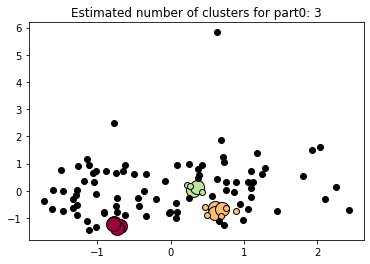

In [121]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters for part0: %d" % n_clusters_)
plt.show()

### Totally Different

In [122]:
X = (df_stimulus_scale[(df_stimulus_scale.stimulus.str.contains("part0"))&(df_stimulus_scale.stimulus.str.contains("pair4|pair5|pair6"))])[["response", "time_elapsed"]]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.22, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 4
Estimated number of noise points: 68


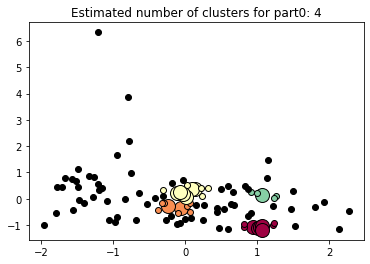

In [123]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters for part0: %d" % n_clusters_)
plt.show()

## Part1 DBSCAN

In [107]:
X = (df_stimulus_scale[df_stimulus_scale.stimulus.str.contains("part1")])[["response", "time_elapsed"]]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.22, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 59


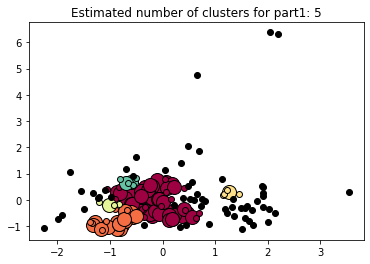

In [108]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters for part1: %d" % n_clusters_)
plt.show()

## Part 2 DBSCAN

In [109]:
X = (df_stimulus_scale[df_stimulus_scale.stimulus.str.contains("part2")])[["response", "time_elapsed"]]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.22, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 78


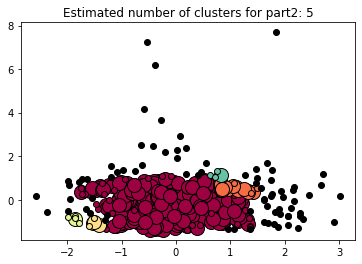

In [110]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters for part2: %d" % n_clusters_)
plt.show()

## Part 3 DBSCAN

In [111]:
X = (df_stimulus_scale[df_stimulus_scale.stimulus.str.contains("part3")])[["response", "time_elapsed"]]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.22, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 56


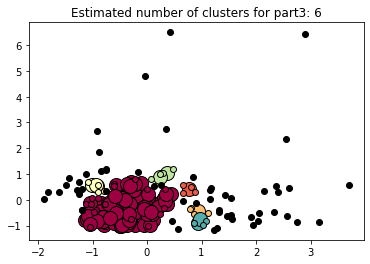

In [112]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters for part3: %d" % n_clusters_)
plt.show()

## Part 4 DBSCAN

In [113]:
X = (df_stimulus_scale[df_stimulus_scale.stimulus.str.contains("part4")])[["response", "time_elapsed"]]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.22, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 62


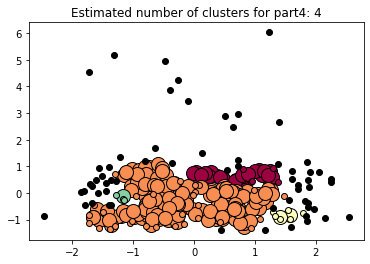

In [114]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters for part4: %d" % n_clusters_)
plt.show()

## Conclusion
From the above figures, we can find that most points are dense, which means the observations are valid.

An interesting finding is that when it comes to exactly same and totally different part, the points are distributed sparely. This may because people are not confident with this two cases and need longer time to judge whether they make correct choice.

# Meet with Nat:
## Experiment data analysis
+ dots plot (to show the real range of points distrubution) and sort them in decsending / ascending order
+ If there is simpler and more naive similarity analysis, we can compare that
+ Multiple test correction
+ No need to do too much about sex and music background, because we don't have enough data samples
## Paper
+ Paper: We purposed a new model and later use case study